In [1]:
%%shell
pip install kaggle
apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [2]:
%%shell
[[ ! -d "/root/.kaggle" ]] && mkdir "/root/.kaggle"
[[ -f "kaggle.json" ]] && mv "kaggle.json" "/root/.kaggle/"
chmod 600 "/root/.kaggle/kaggle.json"

In [3]:
!tree /root/.kaggle

/root/.kaggle
└── kaggle.json

0 directories, 1 file


In [4]:
!kaggle --help

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...

options:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        kernels {list, init, push, pull, output, status}
                        config {view, set, unset}
    competitions (c)    Commands related to Kaggle competitions
    datasets (d)        Commands related to Kaggle datasets
    kernels (k)         Commands related to Kaggle kernels
    files (f)           Commands related files
    config              Configuration settings


In [5]:
%%shell
kaggle datasets download "ozlerhakan/spam-or-not-spam-dataset"
unzip spam-or-not-spam-dataset.zip

spam-or-not-spam-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  spam-or-not-spam-dataset.zip
replace spam_or_not_spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import torch
from torch import Tensor
from torch.nn import Embedding, Module, MultiheadAttention, Linear, Sequential
from torch.nn import functional as F
from torch.optim import Adam
from numpy.typing import ArrayLike
from scipy import stats
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from typing import List, Set, Callable, Generator, Tuple
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tqdm.notebook import tqdm

nltk.download("punkt")
plt.style.use("ggplot")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df = pd.read_csv("spam_or_not_spam.csv")

In [8]:
df

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [9]:
def preprocess(text: str) -> str | None:
    try:
        tokens = word_tokenize(text)
        tokenized_text = " ".join(tokens)
        lower_text = tokenized_text.lower()
        spchar_text = re.sub(r"[^a-z]", " ", lower_text)
        dupspc_text = re.sub(r" +", " ", spchar_text)
        return dupspc_text
    except:
        return None

In [10]:
df_preprocess = df.assign(email=df.email.apply(preprocess)).dropna()

In [11]:
df_preprocess

,email,label
0,date wed number aug number number number numbe...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which h...,0
...,...,...
2995,abc s good morning america ranks it the number...,1
2996,hyperlink hyperlink hyperlink let mortgage len...,1
2997,thank you for shopping with us gifts for all o...,1
2998,the famous ebay marketing e course learn to se...,1


In [12]:
def get_vocab(text: str) -> Set[str]:
    return set(text.split())
class Vocab:
    corpus: List[str]
    int2str: pd.Series
    str2int: pd.Series

    def __init__(self, device: torch.device, n_jobs: int = 4):
        self.device = device
        self.n_jobs = n_jobs

    def __len__(self) -> int:
        return self.int2str.size

    def set_corpus(self, corpus: List[str]) -> "Vocab":
        self.corpus = corpus
        return self

    def compute(self) -> "Vocab":
        with Pool(processes=self.n_jobs) as p:
            vocabs = p.map(get_vocab, self.corpus)
        vocab = ["<PAD>"] + list(reduce(lambda a, b: a | b, vocabs, set()))
        self.int2str = pd.Series(vocab)
        self.str2int = pd.Series(
            index = vocab,
            data=np.arange(self.int2str.size)
        )
        return self

    def transform(self, tokens: List[str]) -> Tensor:
        return torch.tensor(
            self.str2int[tokens].to_numpy()
        ).to(self.device)

    def inverse_transform(self, tokens: Tensor) -> List[str]:
        return self.int2str[tokens.cpu().numpy()].to_list()

In [13]:
set(["hola", "hola", "chao", "adios"])

{'adios', 'chao', 'hola'}

In [14]:
vocab = Vocab(device=torch.device("cuda"), n_jobs=1)

In [15]:
vocab = (
    Vocab(device=torch.device("cuda"), n_jobs=4)
    .set_corpus(df_preprocess.email.to_list())
    .compute()
)

In [16]:
vocab.transform(["channing", "probably"])

tensor([6175, 5078], device='cuda:0')

In [17]:
vocab.inverse_transform(vocab.transform(["channing", "probably"]))

['channing', 'probably']

In [18]:
class Tokenizer:
    def __init__(self, vocab: Vocab, padding: int):
        self.vocab = vocab
        self.padding = padding

    def process_text(self, text: str) -> Tensor:
        vect = self.vocab.transform(text.split())
        if sum(vect.shape) < self.padding:
            vect = torch.concat([
                vect, torch.zeros(
                    size=(self.padding - sum(vect.shape), ),
                    dtype=vect.dtype,
                    device=vect.device
                    )
            ])
        elif sum(vect.shape) >= self.padding:
            vect = vect[:self.padding]
        return vect.reshape(1, -1)

    def process(self, corpus: List[str]) -> Tensor:
        vects = list(map(self.process_text, corpus))
        features = torch.concat(vects, axis=0) # type: ignore
        return features

In [19]:
vect = vocab.transform(["channing", "probably"])
sum(vect.shape)

2

In [20]:
tokenizer = Tokenizer(vocab=vocab, padding=10)

In [21]:
tokenizer.process_text("the debug log of the pick")

tensor([[17751, 10724,  9991, 16406, 17751, 26615,     0,     0,     0,     0]],
       device='cuda:0')

In [22]:
df_preprocess.email.iloc[0]

'date wed number aug number number number number number from chris garrigues cwg dated number numberfanumberd deepeddy com message id number number tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening number number number pick it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number ftoc pickmsgs number hit number number number marking number hits number number number tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number hit that s where the number hit comes from obviously the version of nmh i m using is delta pick version pick nmh number number number compiled on url at sun mar number number n

In [23]:
vocab.inverse_transform(tokenizer.process_text("the debug log of the pick").flatten())

['the',
 'debug',
 'log',
 'of',
 'the',
 'pick',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [24]:
len(vocab)

32952

In [25]:
lens = df_preprocess.email.apply(lambda text: len(text.split()))
lens

0       260
1       113
2       256
3       168
4       144
       ... 
2995     96
2996     79
2997    154
2998    747
2999    271
Name: email, Length: 2999, dtype: int64

[Text(0.5, 0, 'Longitudes'), Text(0, 0.5, 'Densidad')]

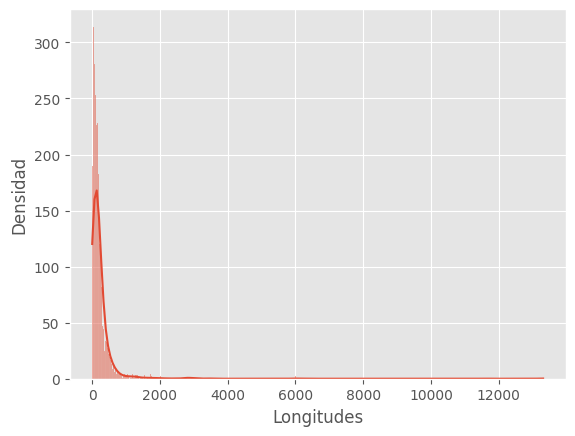

In [26]:
fig, ax = plt.subplots()
sns.histplot(lens, kde=True)
ax.set(xlabel="Longitudes", ylabel="Densidad")

In [27]:
params = stats.pareto.fit(lens)
params

(3.9088134168363253, -642.4657619339744, 642.4657619339742)

In [28]:
dist = stats.pareto(*params)

In [29]:
dist

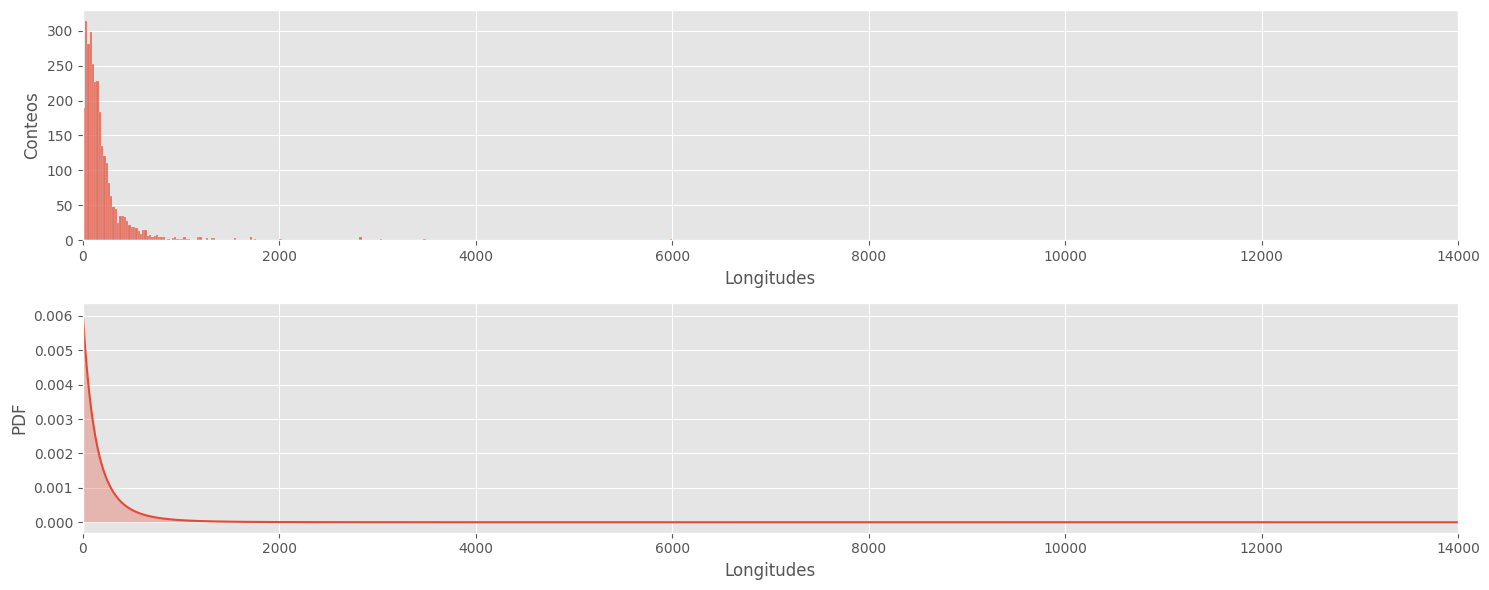

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))
ax = axes[0]
sns.histplot(lens, ax=ax)
ax.set(xlabel="Longitudes", ylabel="Conteos", xlim=[0, 14_000])

ax = axes[1]
x_range = np.linspace(0, 14_000, 1000)
pdf = dist.pdf(x_range)
ax.plot(x_range, pdf)
ax.fill_between(x_range, np.zeros_like(x_range), pdf, alpha=0.3)
ax.set(xlabel="Longitudes", ylabel="PDF", xlim=[0, 14_000])

fig.tight_layout()

$$
\text{CDF}(l) = P(\mathcal{L} < l)
$$

In [31]:
dist.cdf(2000)

0.9960247396852593

In [32]:
padding = int(dist.ppf(0.975))

In [33]:
padding

1008

In [34]:
tokenizer = Tokenizer(vocab=vocab, padding=padding)

In [35]:
features = tokenizer.process(df_preprocess.email.to_list())

In [36]:
features

tensor([[12850, 11697, 21416,  ...,     0,     0,     0],
        [28654, 12093, 31638,  ...,     0,     0,     0],
        [11558, 13339, 17959,  ...,     0,     0,     0],
        ...,
        [14154, 20991, 31420,  ...,     0,     0,     0],
        [17751, 29639, 14273,  ...,     0,     0,     0],
        [ 7902, 25770, 31336,  ...,     0,     0,     0]], device='cuda:0')

In [37]:
" ".join(vocab.inverse_transform(features[0]))

'date wed number aug number number number number number from chris garrigues cwg dated number numberfanumberd deepeddy com message id number number tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening number number number pick it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number ftoc pickmsgs number hit number number number marking number hits number number number tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number hit that s where the number hit comes from obviously the version of nmh i m using is delta pick version pick nmh number number number compiled on url at sun mar number number n

In [38]:
df_preprocess.email.iloc[0]

'date wed number aug number number number number number from chris garrigues cwg dated number numberfanumberd deepeddy com message id number number tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening number number number pick it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number number number ftoc pickmsgs number hit number number number marking number hits number number number tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequence mercury number hit that s where the number hit comes from obviously the version of nmh i m using is delta pick version pick nmh number number number compiled on url at sun mar number number n

In [39]:
emb = Embedding(num_embeddings=3, embedding_dim=4)

In [40]:
x = torch.tensor([[0, 1, 0, 1, 2]])

In [41]:
emb(x)

tensor([[[-0.0358, -0.7660,  0.6078,  0.2639],
         [ 0.5927,  0.5661, -0.1042,  0.8168],
         [-0.0358, -0.7660,  0.6078,  0.2639],
         [ 0.5927,  0.5661, -0.1042,  0.8168],
         [ 0.6541, -0.3709,  1.8342, -0.0430]]], grad_fn=<EmbeddingBackward0>)

In [42]:
emb = Embedding(num_embeddings=len(vocab), embedding_dim=10).to("cuda")

In [43]:
h = emb(features)

In [44]:
h.shape # (n_documents, n_words, n_embedding)

torch.Size([2999, 1008, 10])

In [45]:
class PositionalEncoding(Module):
    def __init__(self, embedding_dim: int, max_len: int):
        super(PositionalEncoding, self).__init__()

        # Arreglo de posiciones de palabras
        position = torch.arange(max_len).double().reshape(-1, 1)

        # Exponentes
        _2i = torch.arange(0, embedding_dim, 2).double()

        # Arreglo del encoding
        encoding = torch.zeros(size=(1, max_len, embedding_dim)) # (n_documents, n_words, n_embedding)

        # Primera ecuacion
        encoding[0, :, ::2] = torch.sin(
            position / 10_000 ** (_2i / embedding_dim)
            )

        # Segunda ecuacion
        encoding[0, :, 1::2] = torch.cos(
            position / 10_000 ** (_2i / embedding_dim)
            )

        self.register_buffer("encoding", encoding)

    def forward(self, features: Tensor) -> Tensor:
        return features + self.encoding

In [46]:
emb = torch.zeros(size=(1, 10, 50)).double()
emb

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [47]:
pe = PositionalEncoding(embedding_dim=50, max_len=10)

In [48]:
res = pe(emb)

In [49]:
res.shape

torch.Size([1, 10, 50])

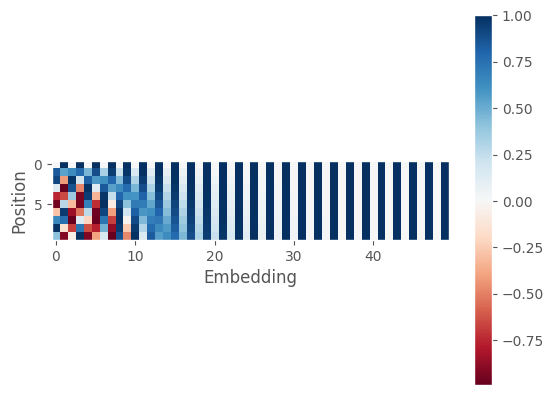

In [50]:
fig, ax = plt.subplots()
im = ax.imshow(res[0], cmap="RdBu")
fig.colorbar(im)
ax.set(xlabel="Embedding", ylabel="Position")
ax.grid(False)

```
0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111
```

In [51]:
def generate_bins(n_bits: int, n_combs: int) -> ArrayLike:
    combs = np.zeros(shape=(n_combs, n_bits))
    for i in range(n_combs):
        vals = list(map(int, bin(i)[2:]))
        combs[i, :len(vals)] = vals[::-1]
    return combs

In [52]:
0b0101

5

In [53]:
bins = generate_bins(50, 10)

In [54]:
bins

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

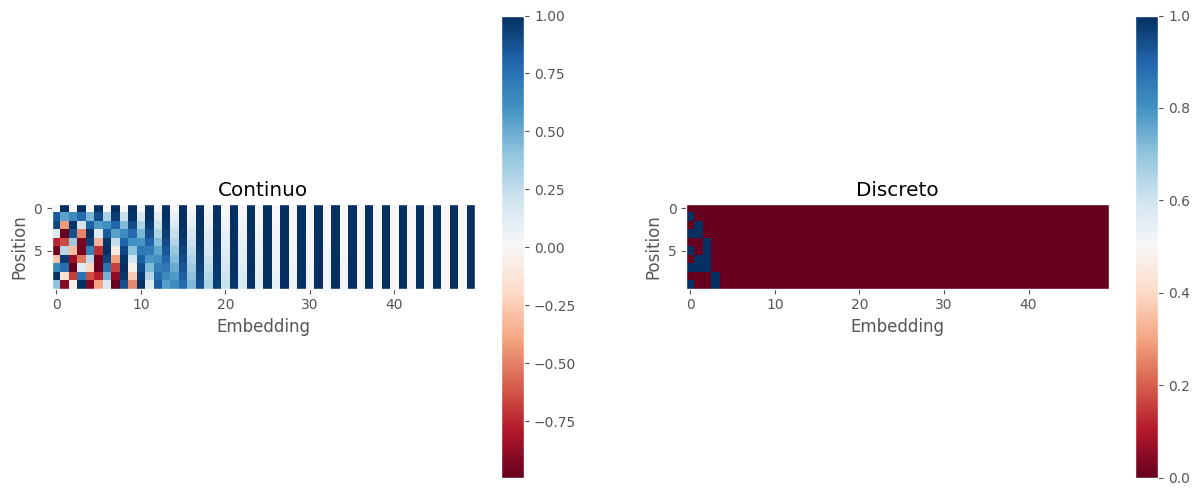

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes[0]
im = ax.imshow(res[0], cmap="RdBu")
fig.colorbar(im)
ax.set(xlabel="Embedding", ylabel="Position", title="Continuo")
ax.grid(False)

ax = axes[1]
im = ax.imshow(bins, cmap="RdBu")
fig.colorbar(im)
ax.set(xlabel="Embedding", ylabel="Position", title="Discreto")
ax.grid(False)

In [56]:
h.shape

torch.Size([2999, 1008, 10])

In [57]:
att = MultiheadAttention(embed_dim=10, num_heads=5, batch_first=True).to("cuda")

In [58]:
seq, att_mat = att(h[:32], h[:32], h[:32])

In [59]:
seq.shape

torch.Size([32, 1008, 10])

In [60]:
att_mat.shape

torch.Size([32, 1008, 1008])

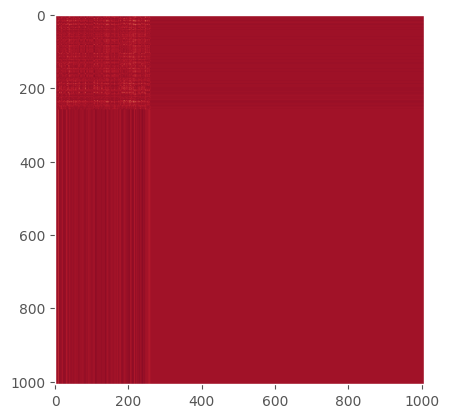

In [61]:
fig, ax = plt.subplots()
ax.imshow(att_mat[0].detach().cpu().numpy(), cmap="RdBu")
ax.grid(False)

In [62]:
len(df_preprocess.email.iloc[0].split())

260

In [63]:
ActType = Callable[[Tensor], Tensor]

class Dense(Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        act_fn: ActType
        ):
        super(Dense, self).__init__()
        self.layer = Linear(in_features=in_features, out_features=out_features)
        self.act_fn = act_fn

    def forward(self, features: Tensor) -> Tensor:
        return self.act_fn(self.layer(features))

class FeedForward(Module):
    def __init__(
        self,
        units_per_layer: List[int],
        act_fns: List[ActType]
        ):
        super(FeedForward, self).__init__()
        self.layers = Sequential(
            *(
                Dense(
                    in_features=in_features, out_features=out_features,
                    act_fn=act_fn
                    )
                for in_features, out_features, act_fn in zip(
                    units_per_layer[:-1], units_per_layer[1:], act_fns
                )
            )
        )

    def forward(self, features: Tensor) -> Tensor:
        return self.layers(features)

In [64]:
class Transformer(Module):
    """
    Custom transformer model.

    Parameters
    ----------
    vocab_size : int
        Vocabulary size.
    embedding_dim : int
        Embedding dimentions.
    padding : int
        Padding size.
    num_heads : int
        Number of heads in the attention layer.
    dropout : float
        Dropout rate in the attention layer.
    units_per_layer : List[int]
        Number of neurons per layer.
    act_fns : List[ActType]
        Activation functions per layer.
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        padding: int,
        num_heads: int,
        dropout: float,
        units_per_layer: List[int],
        act_fns: List[ActType]
        ):
        super(Transformer, self).__init__()
        self.embedding = Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )
        self.positional_encoding = PositionalEncoding(
            embedding_dim=embedding_dim, max_len=padding
        )
        self.attention_layer = MultiheadAttention(
            embed_dim=embedding_dim, num_heads=num_heads, batch_first=True,
            dropout=dropout
        )
        self.feed_foward = FeedForward(
            units_per_layer=units_per_layer,
            act_fns=act_fns
            )

    def forward(self, features: Tensor) -> Tensor:
        emb = self.embedding(features) # embeddings
        # (n_docs, n_words, emb)
        emb_pos = self.positional_encoding(emb) # embeddings con posicion
        # (n_docs, n_words, emb)
        values, _ = self.attention_layer(emb_pos, emb_pos, emb_pos) # embeddings con posicion con ponderacion de atencion
        # (n_docs, n_words, emb)
        doc_emb = values.mean(dim=1)
        # (n_docs, emb)
        output = self.feed_foward(doc_emb)
        return output

In [65]:
class Parent:
    def print_smt(self):
        print("Something")

class Son(Parent):

    def print_parent(self):
        super(Son, self).print_smt()

In [66]:
Son().print_parent()

Something


In [67]:
def sumar(a, b, c):
    return a + b + c

In [68]:
sumar(1, 2, 3)

6

In [69]:
sumar(*(1, 2, 3))

6

In [70]:
model = Transformer(
    vocab_size=len(vocab),
    embedding_dim=30,
    padding=padding,
    num_heads=5,
    dropout=0.2,
    units_per_layer=[30, 32, 16, 2],
    act_fns=[F.relu, F.relu, lambda x: x]
).to("cuda")

In [71]:
pred = model(features[:5])

In [72]:
pred.shape

torch.Size([5, 2])

In [73]:
def batcher(
    features: Tensor, labels: Tensor, batch_size: int
    ) -> Generator[Tuple[Tensor, Tensor], None, None]:
    while True:
        for i in range(0, features.shape[0], batch_size):
            batch_features = features[i: i + batch_size]
            batch_labels = labels[i: i + batch_size]
            yield batch_features, batch_labels

In [74]:
label = df_preprocess.label.to_numpy()

In [75]:
features_np = features.cpu().numpy()

In [76]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features_np, label, test_size=0.3, random_state=3, stratify=label
)

In [77]:
sampler = SMOTE()

In [78]:
np.unique(labels_train, return_counts=True)

(array([0, 1]), array([1750,  349]))

In [79]:
features

tensor([[12850, 11697, 21416,  ...,     0,     0,     0],
        [28654, 12093, 31638,  ...,     0,     0,     0],
        [11558, 13339, 17959,  ...,     0,     0,     0],
        ...,
        [14154, 20991, 31420,  ...,     0,     0,     0],
        [17751, 29639, 14273,  ...,     0,     0,     0],
        [ 7902, 25770, 31336,  ...,     0,     0,     0]], device='cuda:0')

In [80]:
features_train_rs, labels_train_rs = sampler.fit_resample(
    features_train, labels_train
    )

In [81]:
np.unique(labels_train_rs, return_counts=True)

(array([0, 1]), array([1750, 1750]))

In [82]:
features_train_rs = torch.tensor(features_train_rs).to("cuda")
features_test = torch.tensor(features_test).to("cuda")
labels_train_rs = torch.tensor(labels_train_rs).to("cuda")
labels_test = torch.tensor(labels_test).to("cuda")

In [83]:
features_train_rs.shape

torch.Size([3500, 1008])

In [84]:
features_test.shape

torch.Size([900, 1008])

In [85]:
labels_train_rs.shape

torch.Size([3500])

In [86]:
labels_test.shape

torch.Size([900])

In [87]:
features_train_rs

tensor([[16406, 30056, 15335,  ...,     0,     0,     0],
        [32182,  1173, 21416,  ...,     0,     0,     0],
        [17751, 14142, 13821,  ...,     0,     0,     0],
        ...,
        [30204, 18225, 24827,  ...,     0,     0,     0],
        [ 4595, 12340, 18044,  ..., 20971, 19509, 20971],
        [30958,  9431, 16736,  ...,     0,     0,     0]], device='cuda:0')

In [88]:
train_gen = batcher(features_train_rs, labels_train_rs, 128)
test_gen = batcher(features_test, labels_test, 128)

In [89]:
batch_features, batch_labels = next(train_gen)

In [90]:
batch_features.shape

torch.Size([128, 1008])

In [91]:
batch_labels.shape

torch.Size([128])

In [92]:
def loss(x_batch: Tensor, y_batch: Tensor, model: Module) -> Tensor:
    y_pred = model(x_batch)
    loss_val = F.cross_entropy(y_pred, y_batch)
    return loss_val

In [93]:
opt = Adam(model.parameters(), lr=1e-5)

In [94]:
pbar = tqdm(range(50))
train_loss, test_loss = [], []

for _ in pbar:
    train_loss_epoch, test_loss_epoch = [], []
    for _ in range(labels_train_rs.shape[0] // 128):
        batch_features, batch_labels = next(train_gen)
        loss_val = loss(batch_features, batch_labels, model)
        loss_val.backward()
        opt.step()
        train_loss_epoch.append(loss_val.detach().cpu().numpy())

    for _ in range(labels_test.shape[0] // 128):
        batch_features, batch_labels = next(test_gen)
        loss_val = loss(batch_features, batch_labels, model)
        loss_val.backward()
        opt.step()
        test_loss_epoch.append(loss_val.detach().cpu().numpy())
    train_loss.append(np.sum(train_loss_epoch))
    test_loss.append(np.sum(test_loss_epoch))
    pbar.set_description(
        f"Train: {train_loss[-1]:.4f}\tTest: {test_loss[-1]:.4f}"
        )

  0%|          | 0/50 [00:00<?, ?it/s]

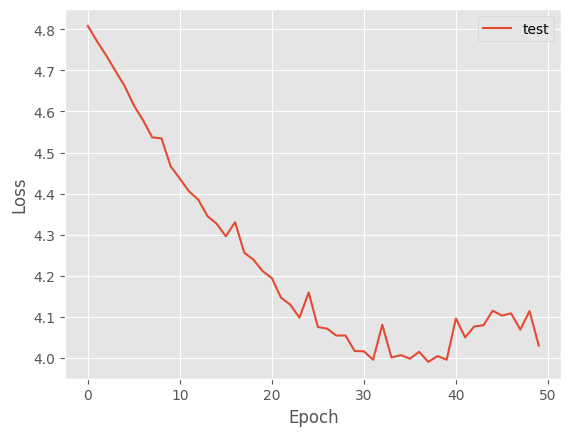

In [104]:
fig, ax = plt.subplots()
#ax.plot(train_loss, label="Train")
ax.plot(test_loss, label="test")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()

In [97]:
test_gen = batcher(features_test, labels_test, 128)

In [98]:
y_pred, y_true = [], []
for _ in range(labels_test.shape[0] // 128):
    batch_features, batch_labels = next(test_gen)
    y_pred_batch = model(batch_features).detach().cpu().numpy()
    y_pred.append(np.argmax(y_pred_batch, axis=1))
    y_true.append(batch_labels.detach().cpu().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [99]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [101]:
y_true

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [103]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       746
           1       0.31      0.25      0.28       150

    accuracy                           0.78       896
   macro avg       0.58      0.57      0.57       896
weighted avg       0.76      0.78      0.77       896

